# Forex predictions using Machine Learning
# Loading and preparing data

In [1]:
import pandas as pd
df = pd.read_csv("EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")
df.tail()

,Gmt time,open,high,low,close,volume
28855,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63
28856,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66
28857,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33
28858,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53
28859,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05


In [2]:
#Check if any zero volumes are available
indexZeros = df[ df['volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["volume"] == 0 )]
df.isna().sum()

Gmt time    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

In [3]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [4]:
df.tail()

,Gmt time,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
28855,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63,0.001947,59.946065,1.160290,1.156618,1.159121,1.167880,0.000054,-0.000132,-0.000149,-0.000162,-1.237279
28856,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66,0.001947,58.038673,1.160920,1.156768,1.159014,1.167745,0.000090,-0.000125,-0.000145,0.000035,-0.095942
28857,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33,0.001965,53.777344,1.160080,1.156853,1.158880,1.167604,0.000115,-0.000123,-0.000140,0.000233,0.033494
28858,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53,0.001972,54.744468,1.159980,1.156944,1.158774,1.167468,0.000122,-0.000118,-0.000137,0.000164,-0.619952
28859,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05,0.001937,57.520290,1.159965,1.157065,1.158678,1.167336,0.000117,-0.000113,-0.000136,0.000028,-0.346306


# Target categories

In [5]:
# TODO: Understand this function

#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [6]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.tail()

,Gmt time,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12166,1.12274,95533.0976,NaN,NaN,1.122600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,05.05.2003 01:00:00.000,1.12242,1.12276,1.12067,1.12126,93778.5996,NaN,NaN,1.121715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,05.05.2003 05:00:00.000,1.12139,1.12255,1.12030,1.12113,90924.6992,NaN,NaN,1.121425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,05.05.2003 09:00:00.000,1.12092,1.12331,1.12049,1.12174,91254.6992,NaN,NaN,1.121900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,05.05.2003 13:00:00.000,1.12194,1.12900,1.12130,1.12712,308003.4083,NaN,NaN,1.125150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


# Quick analysis example

/var/folders/9j/zg2w0vvd4kd1c9dmf275gb2h0000gn/T/ipykernel_60176/2271519335.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


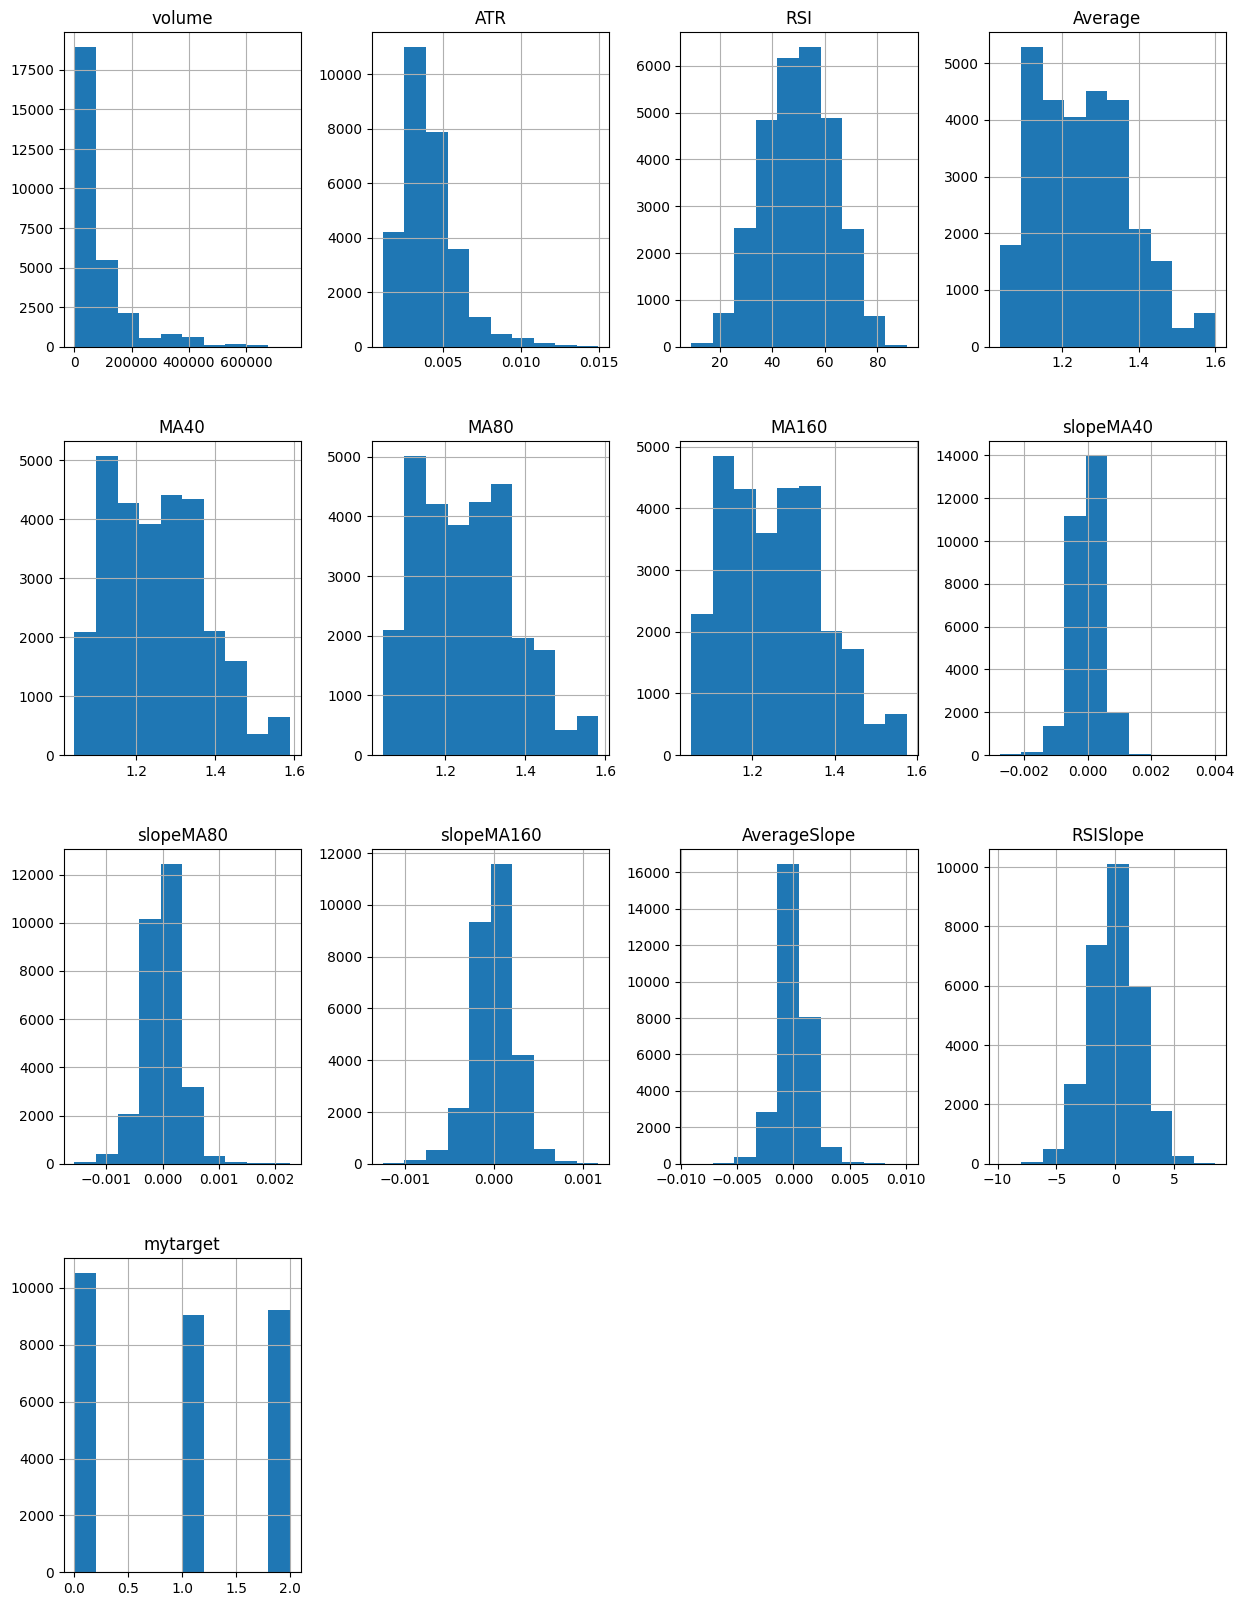

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

## Can we use the RSI alone as a trend indicator?

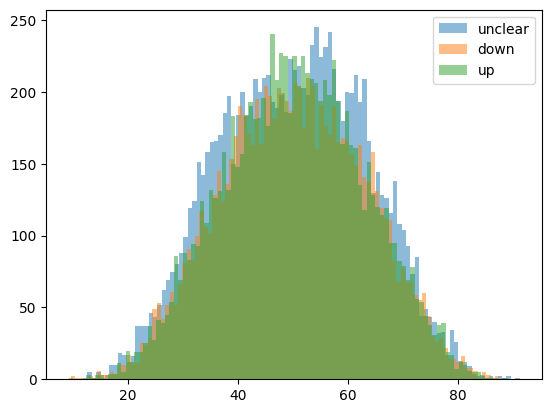

In [8]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

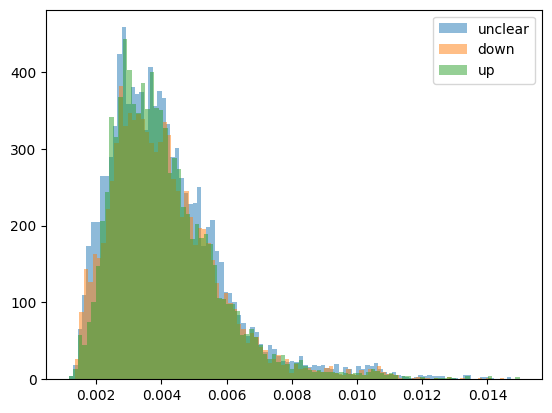

In [9]:
from matplotlib import pyplot
df_up=df.ATR[ df['mytarget'] == 2 ]
df_down=df.ATR[ df['mytarget'] == 1 ]
df_unclear=df.ATR[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

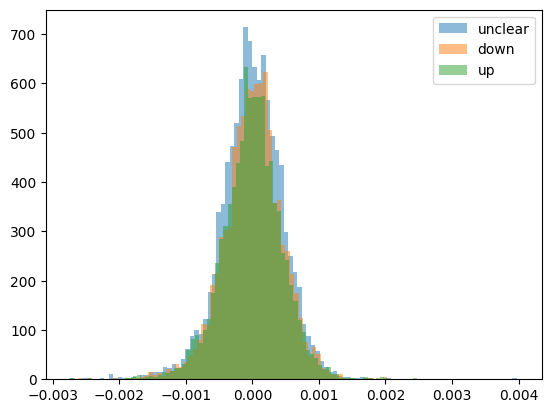

In [10]:
from matplotlib import pyplot
df_up=df.slopeMA40[ df['mytarget'] == 2 ]
df_down=df.slopeMA40[ df['mytarget'] == 1 ]
df_unclear=df.slopeMA40[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

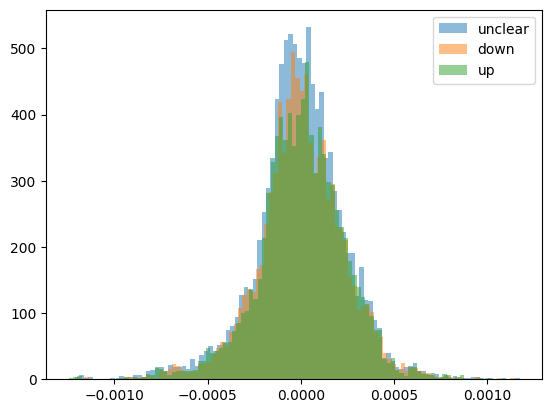

In [16]:
from matplotlib import pyplot
df_up=df.slopeMA160[ df['mytarget'] == 2 ]
df_down=df.slopeMA160[ df['mytarget'] == 1 ]
df_unclear=df.slopeMA160[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

# Machine learning for trend prediction

## 1 - the perfect model with precise prediction

## 2 - less perfect model still with > 40% precision

## 3 - much less perfect model with precision >35% taking into account our strategy, and our TP/SL ratio 

### can't let an automated program run your trades
### it can be your version of a smart indicator (based on machine learning)

## 4 - Our target has categorical values so we need a classificator, KNN?

## Splitting features and target

In [18]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

            ATR        RSI   Average      MA40      MA80     MA160  slopeMA40  \
165    0.004686  47.386257  1.170530  1.172736  1.176061  1.164331  -0.000036   
166    0.004764  55.656867  1.173140  1.172751  1.176156  1.164627  -0.000027   
167    0.004734  57.204154  1.176115  1.172805  1.176219  1.164922  -0.000018   
168    0.004633  53.170749  1.175325  1.172773  1.176158  1.165207  -0.000010   
169    0.004554  55.081423  1.174810  1.172729  1.176124  1.165467  -0.000010   
...         ...        ...       ...       ...       ...       ...        ...   
28837  0.001848  42.935233  1.155445  1.157715  1.162374  1.171109  -0.000059   
28838  0.001830  46.375154  1.156295  1.157628  1.162216  1.170905  -0.000075   
28839  0.001907  37.631843  1.155025  1.157479  1.162006  1.170692  -0.000098   
28840  0.001937  33.174435  1.153790  1.157292  1.161765  1.170473  -0.000121   
28841  0.001894  34.656247  1.152975  1.157129  1.161517  1.170262  -0.000141   

       slopeMA80  slopeMA16

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Fitting the KNN model

In [21]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Quick evaluation of our fitting

In [22]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 38.66%
Accuracy test: 37.46%
0.0    36.545175
2.0    32.034632
1.0    31.420193
Name: mytarget, dtype: float64
Accuracy Gambler: 32.66%


## More powerful model XGBoost

In [24]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 81.1783%
****Test Results****
Accuracy: 50.1658%


## !!Data sampling shouldn't be random

In [25]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

C:\Users\sohai\AppData\Local\Temp\ipykernel_18648\3445858648.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train, y_test = y[:train_index], y[train_index:]


****Train Results****
Accuracy: 80.3229%
****Test Results****
Accuracy: 31.2620%


## Which features are most important for our model?

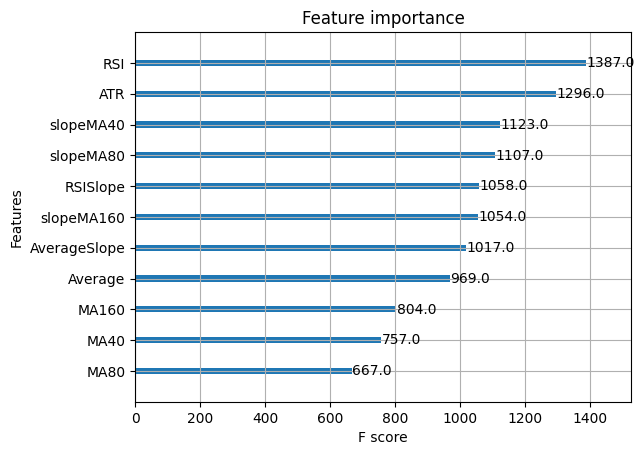

In [26]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

# Automated orders using python and Machine Learning
## Previous videos
### 1 - Install Anaconda, Jupyter NB, Pandas_TA (Technical Analysis)
### 2 - Download price data from online resources, and add our technical indicators to our exchange price dataframe
### 3 - Fit a Machine learning model and predict future price trends using KNN and XGBOOST classifiers
### 4 - Save and Load a ML model,
### - according to the model's advice
### - passing orders (sell/buy) automatically
### - send an email notification about newly applied trading operations

## Load Machine Learning Model from Disk and Test it

In [27]:
import joblib

# save your ML model to disk
filename = 'mymodel1.sav'
joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

## Live Automated Orders with email notification

In [28]:
from apscheduler.schedulers.blocking import BlockingScheduler
import json
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails


import smtplib
gmail_user = 'email@gmail.com'
gmail_password = 'email password here'
sent_from = gmail_user
to = ['email@gmail.com']
subject = 'info CHF'


ModuleNotFoundError: No module named 'apscheduler'

In [ ]:
ModelPrediction = 0
def some_job():
    access_token="INSERT TOKEN HERE, YOU GET IT FROM YOUR OANDA ACCOUNT"
    collector = CandleCollector(access_token, Pair.USD_CHF, Gran.H4)
    candles = collector.grab(2*161)

    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    #dfstream['Average'] = (dfstream['High']+dfstream['Low'])/2
    #dfstream['MA40'] = dfstream['Open'].rolling(window=40).mean()
    #dfstream['MA80'] = dfstream['Open'].rolling(window=80).mean()
    #dfstream['MA160'] = dfstream['Open'].rolling(window=160).mean()
    
    import numpy as np
    import pandas_ta as ta
    #attributes=['ATR', 'RSI', 'Average', 
    #'MA40', 'MA80', 'MA160', 'slopeMA40', 
    #'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    dfstream['ATR'] = dfstream.ta.atr(length=20)
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Average'] = dfstream.ta.midprice(length=1) #midprice
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)

#from scipy.stats import linregress
#def get_slope(array):
#    y = np.array(array)
#    x = np.arange(len(y))
#    slope, intercept, r_value, p_value, std_err = linregress(x,y)
#    return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    #________________________________________________________________________________________________
    X_stream = dfstream.iloc[[320]]# !!! Index takes last CLOSED candle
    #attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 
    #'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X_model = X_stream[attributes]
    
    # Apply the model for predictions
    ModelPrediction = loaded_model.predict(X_model)
  
    msg = str(ModelPrediction) # 0 no clear trend, 1 downtrend, 2 uptrend
    #------------------------------------
    # send email with 
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, msg)
    server.close()
    #________________________________________________________________________________________________
    
    
    # EXECUTING ORDERS
    accountID = "1432-432-0000" #use your account ID
    client = API(access_token)

    candles = collector.grab(1)
#    for candle in candles:
#        print(candle.bid.o)
#        print(candle.bid.c)
    
    pipdiff = 500*1e-5 #for TP
    SLTPRatio = 2 #pipdiff/Ratio gives SL
    
    TPBuy = float(str(candle.bid.o))+pipdiff
    SLBuy = float(str(candle.bid.o))-(pipdiff/SLTPRatio)
    TPSell = float(str(candle.bid.o))-pipdiff
    SLSell = float(str(candle.bid.o))+(pipdiff/SLTPRatio)
    
    #Sell
    if ModelPrediction == 1:
        mo = MarketOrderRequest(instrument="USD_CHF", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif ModelPrediction == 2:
        mo = MarketOrderRequest(instrument="USD_CHF", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)

## Executing orders automatically every 4 Hours

In [ ]:
#some_job()

###################################################################
## Interval time job ##############################################
scheduler = BlockingScheduler(job_defaults={'misfire_grace_time': 15*60})
scheduler.add_job(some_job, 'cron', day_of_week='mon-fri', hour='*/4', minute=5, jitter=120, timezone='America/New_York')
#scheduler.add_job(some_job, 'interval', hours=4)
scheduler.start()

V20Error: {"errorMessage":"Insufficient authorization to perform request."}